# Fourier analysis & resonances

A great benefit of being able to call rebound from within python is the ability to directly apply sophisticated analysis tools from scipy and other python libraries.  Here we will do a simple Fourier analysis of a reduced Solar System consisting of Jupiter and Saturn.  Let's begin by setting our units and adding these planets using JPL's horizons database:

In [1]:
import rebound
import numpy as np
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.add("Sun")
sim.add("Jupiter")
sim.add("Saturn")

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).


Now let's set the integrator to whfast, and sacrificing accuracy for speed, set the timestep for the integration to about $10\%$ of Jupiter's orbital period.

In [2]:
sim.integrator = "whfast"
sim.dt = 1. # in years.  About 10% of Jupiter's period
sim.move_to_com()

The last line (moving to the center of mass frame) is important to take out the linear drift in positions due to the constant COM motion.  Without it we would erase some of the signal at low frequencies.

Now let's run the integration, storing time series for the two planets' eccentricities (for plotting) and x-positions (for the Fourier analysis).  Additionally, we store the mean longitudes and pericenter longitudes (varpi) for reasons that will become clear below.  Having some idea of what the secular timescales are in the Solar System, we'll run the integration for $3\times 10^5$ yrs.  We choose to collect $10^5$ outputs in order to resolve the planets' orbital periods ($\sim 10$ yrs) in the Fourier spectrum.

In [3]:
Nout = 100000
tmax = 3.e5
Nplanets = 2

x = np.zeros((Nplanets,Nout))
ecc = np.zeros((Nplanets,Nout))
longitude = np.zeros((Nplanets,Nout))
varpi = np.zeros((Nplanets,Nout))

times = np.linspace(0.,tmax,Nout)
ps = sim.particles

for i,time in enumerate(times):
    sim.integrate(time) 
    # note we used above the default exact_finish_time = 1, which changes the timestep near the outputs to match
    # the output times we want.  This is what we want for a Fourier spectrum, but technically breaks WHFast's
    # symplectic nature.  Not a big deal here.
    os = sim.orbits()
    for j in range(Nplanets):
        x[j][i] = ps[j+1].x  # we use the 0 index in x for Jup and 1 for Sat, but the indices for ps start with the Sun at 0
        ecc[j][i] = os[j].e
        longitude[j][i] = os[j].l
        varpi[j][i] = os[j].Omega + os[j].omega

Let's see what the eccentricity evolution looks like with matplotlib:

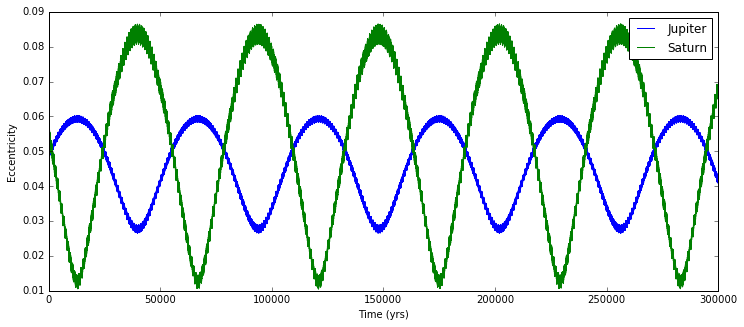

In [11]:
%matplotlib inline
labels = ["Jupiter", "Saturn"]
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,ecc[0],label=labels[0])
plt.plot(times,ecc[1],label=labels[1])
ax.set_xlabel("Time (yrs)")
ax.set_ylabel("Eccentricity")
plt.legend();

Now let's try to analyze the periodicities in this signal.  Here we have a uniformly spaced time series, so we could run a Fast Fourier Transform, but as an example of the wider array of tools available through scipy, let's run a Lomb-Scargle periodogram (which allows for non-uniform time series). This could also be used when storing outputs at each timestep using the integrator IAS15 (which uses adaptive and therefore non-uniform timesteps).

Let's check for periodicities with periods logarithmically spaced between 10 and $10^5$ yrs.  From the documentation, we find that the lombscargle function requires a list of corresponding angular frequencies (ws), and we obtain the appropriate normalization for the plot.  To avoid conversions to orbital elements, we analyze the time series of Jupiter's x-position.

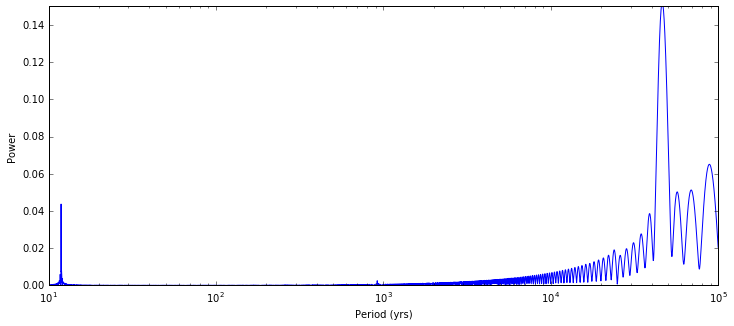

In [10]:
from scipy import signal
Npts = 3000
logPmin = np.log10(10.)
logPmax = np.log10(1.e5)
Ps = np.logspace(logPmin,logPmax,Npts)
ws = np.asarray([2*np.pi/P for P in Ps])

periodogram = signal.lombscargle(times,x[0],ws)

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(Ps,np.sqrt(4*periodogram/Nout))
ax.set_xscale('log')
ax.set_xlim([10**logPmin,10**logPmax])
ax.set_ylim([0,0.15])
ax.set_xlabel("Period (yrs)")
ax.set_ylabel("Power")

We pick out the obvious signal in the eccentricity plot with a period of $\approx 45000$ yrs, which is due to secular interactions between the two planets.  There is quite a bit of power aliased into neighbouring frequencies due to the short integration duration, with contributions from the second secular timescale, which is out at $\sim 2\times10^5$ yrs and causes a slower, low-amplitude modulation of the eccentricity signal plotted above (we limited the time of integration so that the example runs in a few seconds).  

Additionally, though it was invisible on the scale of the eccentricity plot above, we clearly see a strong signal at Jupiter's orbital period of about 12 years.  

But wait!  Even on this scale set by the dominant frequencies of the problem, we see an additional blip just below $10^3$ yrs.  Such a periodicity is actually visible in the above eccentricity plot if you inspect the thickness of the lines. Let's investigate by narrowing the period range:

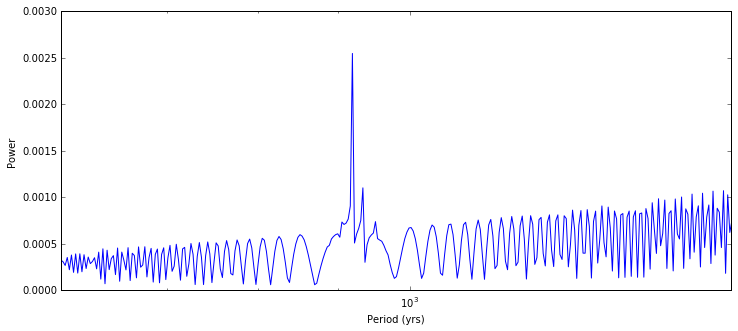

In [12]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(Ps,np.sqrt(4*periodogram/Nout))
ax.set_xscale('log')
ax.set_xlim([600,1600])
ax.set_ylim([0,0.003])
ax.set_xlabel("Period (yrs)")
ax.set_ylabel("Power")

This is the right timescale to be due to resonant perturbations between giant planets ($\sim 100$ orbits).  In fact, Jupiter and Saturn are close to a 5:2 mean-motion resonance.  This is the famous great inequality that Laplace showed was responsible for slight offsets in the predicted positions of the two giant planets.  Let's check whether this is in fact responsible for the peak.  

In this case, we have that the mean longitude of Jupiter $\lambda_J$ cycles approximately 5 times for every 2 of Saturn's ($\lambda_S$).  The game is to construct a slowly-varying resonant angle, which here could be $\phi_{5:2} = 5\lambda_S - 2\lambda_J - 3\varpi_J$, where $\varpi_J$ is Jupiter's longitude of pericenter.  This last term is a much smaller contribution to the variation of $\phi_{5:2}$ than the first two, but ensures that the coefficients in the resonant angle sum to zero and therefore that the physics do not depend on your choice of coordinates.

To see a clear trend, we have to shift each value of $\phi_{5:2}$ into the range $[0,360]$ degrees, so we define a small helper function that does the wrapping and conversion to degrees:

In [7]:
def zeroTo360(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val*180/np.pi

Now we construct $\phi_{5:2}$ and plot it over the first 5000 yrs. 

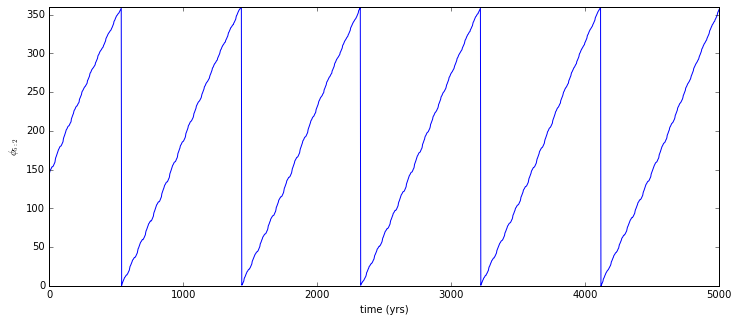

In [13]:
phi = [zeroTo360(5.*longitude[1][i] - 2.*longitude[0][i] - 3.*varpi[0][i]) for i in range(Nout)]
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(times,phi)
ax.set_xlim([0,5.e3])
ax.set_ylim([0,360.])
ax.set_xlabel("time (yrs)")
ax.set_ylabel(r"$\phi_{5:2}$")

We see that the resonant angle $\phi_{5:2}$ circulates, but with a long period of $\approx 900$ yrs (compared to the orbital periods of $\sim 10$ yrs), which precisely matches the blip we saw in the Lomb-Scargle periodogram.  This is approximately the same oscillation period observed in the Solar System, despite our simplified setup!

This resonant angle is able to have a visible effect because its (small) effects build up coherently over many orbits.   As a further illustration, other resonance angles like those at the 2:1 will circulate much faster (because Jupiter and Saturn's period ratio is not close to 2).  We can easily plot this.  Taking one of the 2:1 resonance angles $\phi_{2:1} = 2\lambda_S - \lambda_J - \varpi_J$,

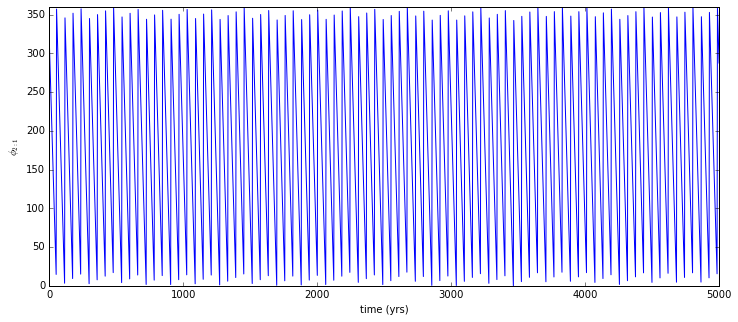

In [14]:
phi2 = [zeroTo360(2*longitude[1][i] - longitude[0][i] - varpi[0][i]) for i in range(Nout)]
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(times,phi2)
ax.set_xlim([0,5.e3])
ax.set_ylim([0,360.])
ax.set_xlabel("time (yrs)")
ax.set_ylabel(r"$\phi_{2:1}$")

In this case, since we are far from this particular resonance (the 2:1), the corresponding resonance angles vary on fast (orbital) timescales, and their effects simply average out.